In [2]:
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import cv2 as cv2
from scipy import ndimage
import random
import pickle
import seaborn as sns
import itertools
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
!pip install scikeras
from scikeras.wrappers import KerasClassifier
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import optimizers
from tensorflow.keras import utils
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

%matplotlib inline

2025-02-21 08:29:40.289499: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-21 08:29:40.479757: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740119380.562132 3271683 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740119380.600314 3271683 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-21 08:29:40.785976: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
!pip install mtcnn
import mtcnn
from mtcnn.mtcnn import MTCNN

In [4]:
def show_img(num, img_array, title, ncols=1):
    '''this function display images from an image array'''
    ncols= ncols
    nrows= int(num/ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize =(ncols*4,nrows*4))
    fig.suptitle(title, size = 20)
    ax = ax.ravel()
    for i in range(num):
        ax[i].imshow(img_array[i][0], cmap='gray')
        ax[i].set_title(label_map.get(img_array[i][1]), size=16)

In [5]:
def crop_and_resize(image, target_w=224, target_h=224):
    '''this function crop & resize images to target size by keeping aspect ratio'''
    if image.ndim == 2:
        img_h, img_w = image.shape             # for Grayscale will be   img_h, img_w = img.shape
    elif image.ndim == 3:
        img_h, img_w, channels = image.shape   # for RGB will be   img_h, img_w, channels = img.shape
    target_aspect_ratio = target_w/target_h
    input_aspect_ratio = img_w/img_h

    if input_aspect_ratio > target_aspect_ratio:
        resize_w = int(input_aspect_ratio*target_h)
        resize_h = target_h
        img = cv2.resize(image, (resize_w , resize_h))
        crop_left = int((resize_w - target_w)/2)  ## crop left/right equally
        crop_right = crop_left + target_w
        new_img = img[:, crop_left:crop_right]
    if input_aspect_ratio < target_aspect_ratio:
        resize_w = target_w
        resize_h = int(target_w/input_aspect_ratio)
        img = cv2.resize(image, (resize_w , resize_h))
        crop_top = int((resize_h - target_h)/4)   ## crop the top by 1/4 and bottom by 3/4 -- can be changed
        crop_bottom = crop_top + target_h
        new_img = img[crop_top:crop_bottom, :]
    if input_aspect_ratio == target_aspect_ratio:
        new_img = cv2.resize(image, (target_w, target_h))

    return new_img

In [6]:

detector = MTCNN()  # creates detector  

def extract_face(img, target_size=(224,224)):
    '''this functions extract the face from different images by 
    1) finds the facial bounding box
    2) slightly expands top & bottom boundaries to include the whole face
    3) crop into a square shape
    4) resize to target image size for modelling
    5) if the facial bounding box in step 1 is not found, image will be cropped & resized to 224x224 square'''
           
    # 1. detect faces in an image
      
    results = detector.detect_faces(img)
    if results == []:    # if face is not detected, call function to crop & resize by keeping aspect ratio
        new_face = crop_and_resize(img, target_w=224, target_h=224)    
    else:
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1+width, y1+height
        face = img[y1:y2, x1:x2]  # this is the face image from the bounding box before expanding bbox

        # 2. expand the top & bottom of bounding box by 10 pixels to ensure it captures the whole face
        adj_h = 10

        #assign value of new y1
        if y1-adj_h <10:
            new_y1=0
        else:
            new_y1 = y1-adj_h

        #assign value of new y2    
        if y1+height+adj_h < img.shape[0]:
            new_y2 = y1+height+adj_h
        else:
            new_y2 = img.shape[0]
        new_height = new_y2 - new_y1

        # 3. crop the image to a square image by setting the width = new_height and expand the box to new width
        adj_w = int((new_height-width)/2)    

        #assign value of new x1
        if x1-adj_w < 0:
            new_x1=0
        else:
            new_x1 = x1-adj_w

        #assign value of new x2
        if x2+adj_w > img.shape[1]:
            new_x2 = img.shape[1]
        else:
            new_x2 = x2+adj_w
        new_face = img[new_y1:new_y2, new_x1:new_x2]  # face-cropped square image based on original resolution

    # 4. resize image to the target pixel size
    sqr_img = cv2.resize(new_face, target_size)   
    return sqr_img


2025-02-21 08:29:51.175095: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [7]:
def plot_results(mod_history, metric, epochs):
      
      # Check out our train loss and test loss over epochs.
      train_metric = mod_history.history[metric]
      val = 'val_' + metric
      test_metric = mod_history.history[val]

      # Set figure size.
      plt.figure(figsize=(12, 8))

      # Generate line plot of training, testing loss over epochs.
      plt.plot(train_metric, label=f'Training {metric}', color='#185fad')
      plt.plot(test_metric, label=f'Testing {metric}', color='orange')

      # Set title
      plt.title(f'Training and Testing {metric} by Epoch', fontsize = 25)
      plt.xlabel('Epoch', fontsize = 18)
      plt.ylabel('Categorical Crossentropy', fontsize = 18)
      plt.xticks(range(0,epochs,6), range(0,epochs,6))
      plt.legend(fontsize = 18);

In [8]:
def make_predictions(mod_name, steps=20):
    preds = mod_name.predict(X_test,steps=steps)
    preds = preds.argmax(axis=-1)

    y_test_labels = np.argmax(y_test, axis=-1)

    cm = confusion_matrix(y_test_labels,preds)

    plot_confusion_matrix(cm, cm_plot_labels, normalize=True,
                          title='Face Shape Normalized')

    plt.show()

In [9]:
cm_plot_labels = ['Heart','Rectangle','Oval','Round', 'Square', 'Triangle']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(16,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [10]:
def plot_summary_results(mod_name, mod_history, epochs):
    plot_results(mod_history, 'loss',epochs)
    plot_results(mod_history, 'accuracy', epochs)
    make_predictions(mod_name)

In [11]:
# create path to images in examples

ex_path = './examples'
ex_files = os.listdir(ex_path)

examples = []

for i in ex_files:
    img = os.path.join(ex_path,i)
    examples.append(img)
    
examples = sorted(examples)
# examples

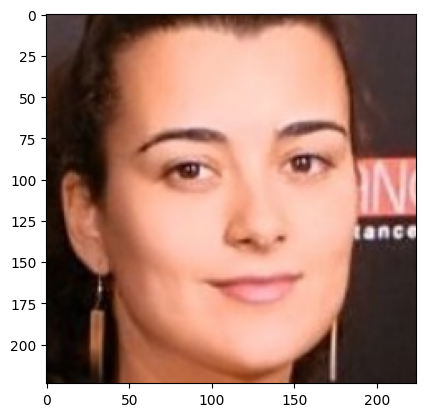

In [14]:
# from the image that we've previously cropped with face detection bounding box
img = cv2.imread(examples[2])
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
new_face = extract_face(rgb)
plt.imshow(new_face);

Text(0.83, 0.08, '-20 degrees')

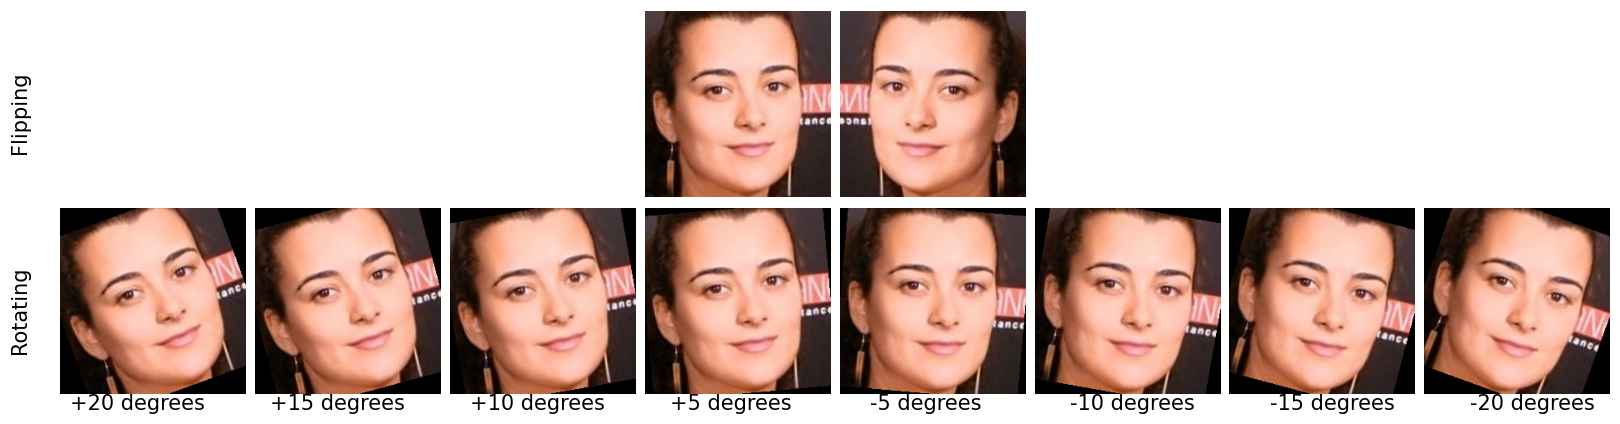

In [15]:
# Augmenting the above image and plotting the augmented images in subplots below.

fig, ax = plt.subplots(nrows=2, ncols=8, figsize=((8*2.5), (2*2.5)))
plt.subplots_adjust(hspace=0.05, wspace=0.05)

ax= ax.ravel()
for i in range(16):
    ax[i].axis('off')

# Original image.
ax[3].imshow(new_face)

# Augmented image: original image flipped laterally.
img_flip = np.fliplr(new_face)
ax[4].imshow(img_flip)

# Augmented image: original image with 5deg rotation.
img_rot_pos5 = ndimage.rotate(new_face, 5, reshape=False)
ax[11].imshow(img_rot_pos5)

# Augmented image: original image with 10deg rotation.
img_rot_pos10 = ndimage.rotate(new_face, 10, reshape=False)
ax[10].imshow(img_rot_pos10)

# Augmented image: original image with 15deg rotation.
img_rot_pos15 = ndimage.rotate(new_face, 15, reshape=False)
ax[9].imshow(img_rot_pos15)

# Augmented image: original image with 20deg rotation.
img_rot_pos20 = ndimage.rotate(new_face, 20, reshape=False)
ax[8].imshow(img_rot_pos20)

# Augmented image: original image with -5deg rotation.
img_rot_neg5 = ndimage.rotate(new_face, -5, reshape=False)
ax[12].imshow(img_rot_neg5)

# Augmented image: original image with -10deg rotation.
img_rot_neg10 = ndimage.rotate(new_face, -10, reshape=False)
ax[13].imshow(img_rot_neg10)

# Augmented image: original image with -15deg rotation.
img_rot_neg15 = ndimage.rotate(new_face, -15, reshape=False)
ax[14].imshow(img_rot_neg15)

# Augmented image: original image with -20deg rotation.
img_rot_neg20 = ndimage.rotate(new_face, -20, reshape=False)
ax[15].imshow(img_rot_neg20)

plt.figtext(x=0.1, y=0.60, s="Flipping", fontsize=15, rotation=90)
plt.figtext(x=0.1, y=0.20, s="Rotating", fontsize=15, rotation=90)
plt.figtext(x=0.13, y=0.08, s="+20 degrees", fontsize=15)
plt.figtext(x=0.23, y=0.08, s="+15 degrees", fontsize=15)
plt.figtext(x=0.33, y=0.08, s="+10 degrees", fontsize=15)
plt.figtext(x=0.43, y=0.08, s="+5 degrees", fontsize=15)
plt.figtext(x=0.53, y=0.08, s="-5 degrees", fontsize=15)
plt.figtext(x=0.63, y=0.08, s="-10 degrees", fontsize=15)
plt.figtext(x=0.73, y=0.08, s="-15 degrees", fontsize=15)
plt.figtext(x=0.83, y=0.08, s="-20 degrees", fontsize=15)

Load in data files (RGB color)

In [12]:
path = './pickle_out/rgb/'

X_train = np.asarray(pickle.load(open(path + "pickle_out_rgbX_train_rgb.pickle","rb")))
y_train = np.asarray(pickle.load(open(path + "pickle_out_rgby_train_rgb.pickle","rb")))
X_test = np.asarray(pickle.load(open(path + "pickle_out_rgbX_test_rgb.pickle","rb")))
y_test = np.asarray(pickle.load(open(path + "pickle_out_rgby_test_rgb.pickle","rb")))

In [14]:
print("Data Summary")
print("--------------------")
print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print("--------------------")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

Data Summary
--------------------
X_train shape (3620, 224, 224, 3)
y_train shape (3620, 6)
--------------------
X_test shape (1204, 224, 224, 3)
y_test shape (1204, 6)


In [15]:
# use rotation of +/- 20 degrees and horizontal flip.  

datagen = ImageDataGenerator(rotation_range=20, horizontal_flip=True, fill_mode='nearest')

In [16]:
datagen.fit(X_train)

In [13]:
model_5 = Sequential()
model_5.add(Conv2D(filters = 8,              # add this layer
                   kernel_size=3,
                   activation='relu',
                   input_shape=X_train.shape[1:]))
model_5.add(MaxPooling2D(pool_size=(2,2)))
model_5.add(Conv2D(filters = 16,              # from 64
                   kernel_size=3,
                   activation='relu'))
model_5.add(MaxPooling2D(pool_size=(2,2)))
model_5.add(Conv2D(filters = 64,             # from 128
                   kernel_size=3,
                   activation='relu'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))
model_5.add(Conv2D(filters = 128,            # from 256
                   kernel_size=3,
                   activation='relu'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))
model_5.add(Flatten())
model_5.add(Dense(32, activation='relu'))    # reduce from 128 to 64 to 32
model_5.add(Dropout(0.5))  ##added
model_5.add(Dense(6, activation='softmax'))

model_5.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

model_5.summary()

/home/vasilemaruseac/jupyter_env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       589,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 674,582 (2.57 MB)

 Trainable params: 674,582 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history_5 = model_5.fit(datagen.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=int(len(X_train)/32), epochs=400, 
                        validation_data=(X_test, y_test))

/home/vasilemaruseac/jupyter_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/400
113/113 ━━━━━━━━━━━━━━━━━━━━ 56s 475ms/step - accuracy: 0.1605 - loss: 1.7945 - val_accuracy: 0.2442 - val_loss: 1.7740
Epoch 2/400
  1/113 ━━━━━━━━━━━━━━━━━━━━ 18s 167ms/step - accuracy: 0.1250 - loss: 1.7756

/home/vasilemaruseac/jupyter_env/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.1250 - loss: 1.7756 - val_accuracy: 0.2409 - val_loss: 1.7728
Epoch 3/400
113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 510ms/step - accuracy: 0.2188 - loss: 1.7632 - val_accuracy: 0.3472 - val_loss: 1.6201
Epoch 4/400
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.2812 - loss: 1.5891 - val_accuracy: 0.3605 - val_loss: 1.6227
Epoch 5/400
113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 554ms/step - accuracy: 0.2769 - loss: 1.6870 - val_accuracy: 0.4369 - val_loss: 1.5397
Epoch 6/400
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.2500 - loss: 1.4837 - val_accuracy: 0.4327 - val_loss: 1.5344
Epoch 7/400
113/113 ━━━━━━━━━━━━━━━━━━━━ 60s 529ms/step - accuracy: 0.3227 - loss: 1.6116 - val_accuracy: 0.4635 - val_loss: 1.4067
Epoch 8/400
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.2812 - loss: 1.6385 - val_accuracy: 0.4726 - val_loss: 1.3975
Epoch 9/400
113/113 ━━━━━━━━━━━━━━━━━━━━ 60s 531ms/step - accuracy: 0.3548 - loss: 1.5166 - val_

In [21]:
model_path = './SavedModels/AGMT.keras'

In [19]:

tf.keras.models.save_model(
    model_5, filepath=model_path, overwrite=True, include_optimizer=True, save_format=None)

filename = model_path + 'agmt_feb19_2025.keras'   # change the filename for new iterations
model_5.save(filename)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step 
Normalized confusion matrix
[[0.98019802 0.00990099 0.0049505  0.         0.         0.0049505 ]
 [0.         0.99       0.         0.01       0.         0.        ]
 [0.         0.00490196 0.99019608 0.         0.         0.00490196]
 [0.         0.         0.         1.         0.         0.        ]
 [0.00505051 0.00505051 0.         0.         0.98989899 0.        ]
 [0.005      0.005      0.         0.01       0.         0.98      ]]


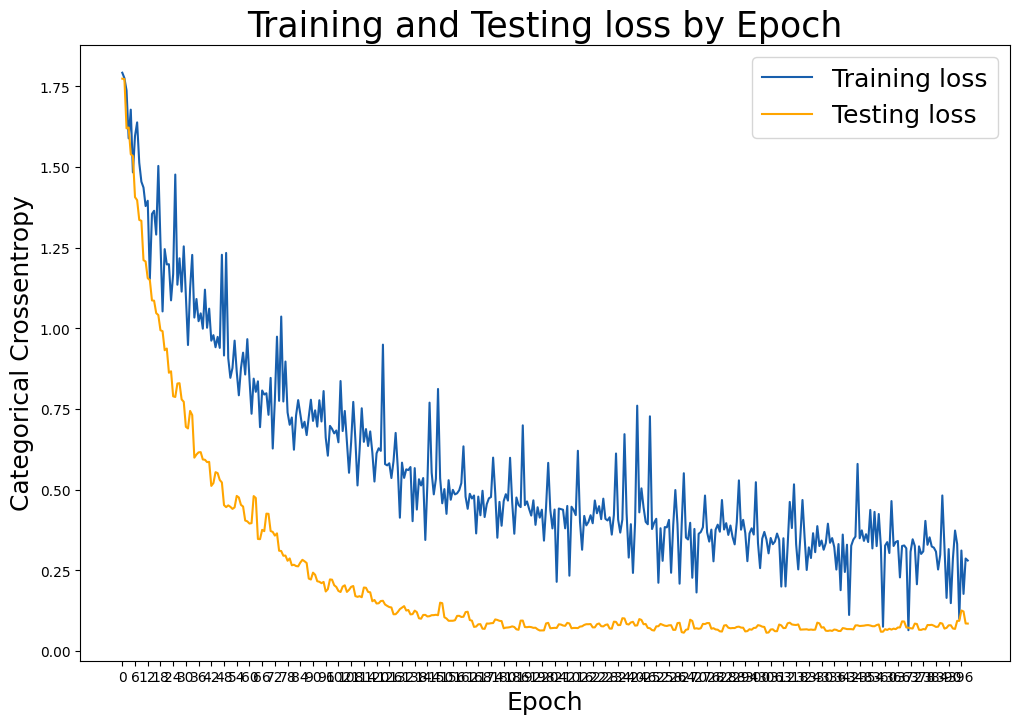

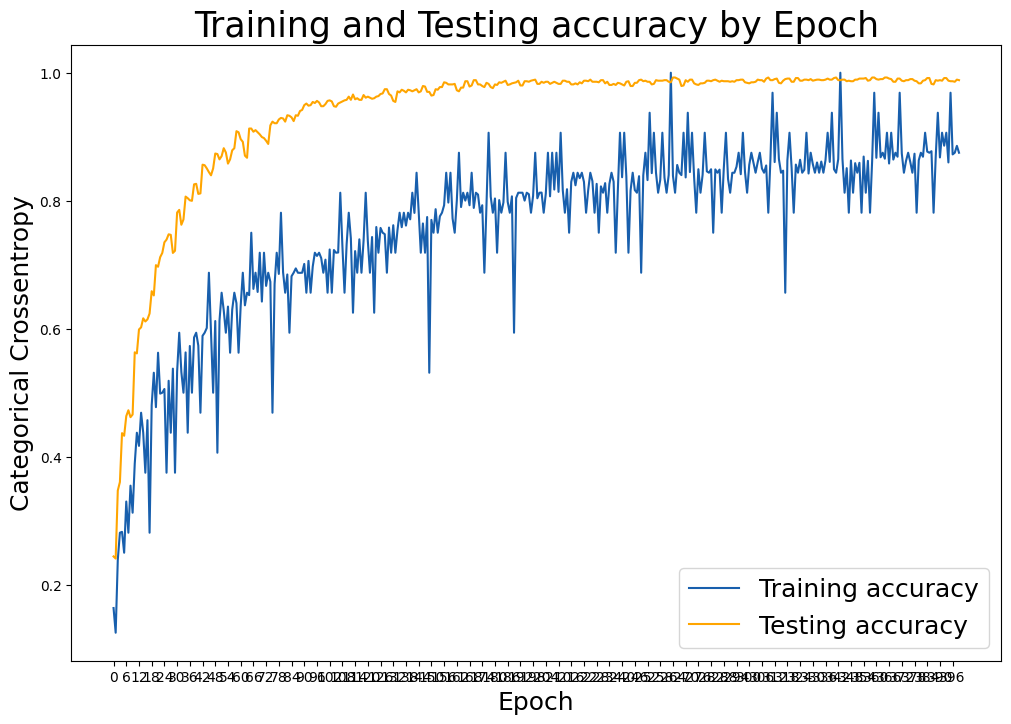

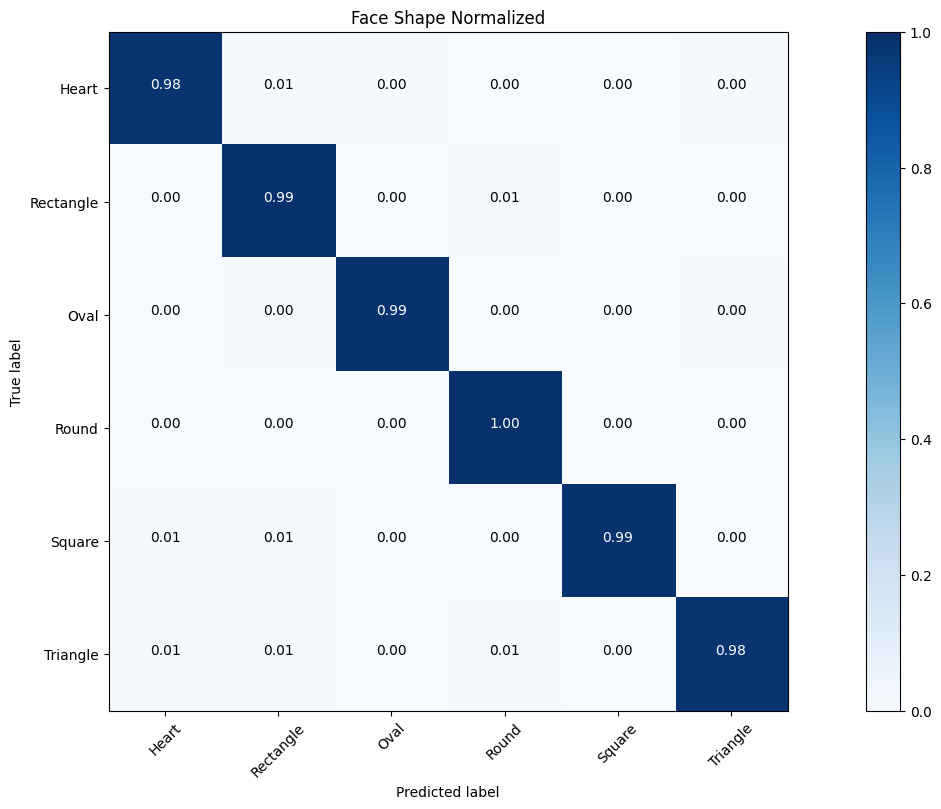

In [20]:
plot_summary_results(model_5, history_5, 400)

In [21]:
history_5_2 = model_5.fit(datagen.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=int(len(X_train)/32), epochs=50, 
                        validation_data=(X_test, y_test))

/home/vasilemaruseac/jupyter_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 44s 386ms/step - accuracy: 0.8655 - loss: 0.3113 - val_accuracy: 0.9867 - val_loss: 0.0894
Epoch 2/50
  1/113 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.8438 - loss: 0.3177

/home/vasilemaruseac/jupyter_env/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8438 - loss: 0.3177 - val_accuracy: 0.9867 - val_loss: 0.0895
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 43s 377ms/step - accuracy: 0.8710 - loss: 0.3132 - val_accuracy: 0.9925 - val_loss: 0.0664
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 1.0000 - loss: 0.1551 - val_accuracy: 0.9925 - val_loss: 0.0665
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 43s 384ms/step - accuracy: 0.8997 - loss: 0.2637 - val_accuracy: 0.9925 - val_loss: 0.0782
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9375 - loss: 0.2270 - val_accuracy: 0.9917 - val_loss: 0.0790
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 43s 380ms/step - accuracy: 0.8896 - loss: 0.2749 - val_accuracy: 0.9917 - val_loss: 0.0755
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9062 - loss: 0.4578 - val_accuracy: 0.9917 - val_loss: 0.0746
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 42s 373ms/step - accuracy: 0.8961 - loss: 0.2486 - val_accurac

In [22]:

history_5_3 = model_5.fit(datagen.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=int(len(X_train)/32), epochs=50, 
                        validation_data=(X_test, y_test))

Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 45s 397ms/step - accuracy: 0.8820 - loss: 0.2678 - val_accuracy: 0.9884 - val_loss: 0.0770
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8750 - loss: 0.1936 - val_accuracy: 0.9884 - val_loss: 0.0775
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 44s 386ms/step - accuracy: 0.9094 - loss: 0.2501 - val_accuracy: 0.9892 - val_loss: 0.0926
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9062 - loss: 0.3393 - val_accuracy: 0.9900 - val_loss: 0.0915
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 43s 383ms/step - accuracy: 0.8976 - loss: 0.2671 - val_accuracy: 0.9917 - val_loss: 0.0893
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9062 - loss: 0.1724 - val_accuracy: 0.9917 - val_loss: 0.0892
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 42s 374ms/step - accuracy: 0.9004 - loss: 0.2478 - val_accuracy: 0.9909 - val_loss: 0.0973
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9062 - loss: 0.2467 - 

In [20]:
history_5_4 = model_5.fit(datagen.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=int(len(X_train)/32), epochs=20, 
                        validation_data=(X_test, y_test))

/home/vasilemaruseac/jupyter_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 48s 415ms/step - accuracy: 0.1732 - loss: 1.7940 - val_accuracy: 0.1669 - val_loss: 1.7915
Epoch 2/20
  1/113 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 0.0625 - loss: 1.7954

/home/vasilemaruseac/jupyter_env/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0625 - loss: 1.7954 - val_accuracy: 0.1669 - val_loss: 1.7915
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 45s 395ms/step - accuracy: 0.1838 - loss: 1.7895 - val_accuracy: 0.2591 - val_loss: 1.7313
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2188 - loss: 1.7367 - val_accuracy: 0.2616 - val_loss: 1.7244
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 44s 394ms/step - accuracy: 0.2098 - loss: 1.7331 - val_accuracy: 0.3248 - val_loss: 1.6061
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3438 - loss: 1.6020 - val_accuracy: 0.3181 - val_loss: 1.6114
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 45s 400ms/step - accuracy: 0.2666 - loss: 1.6678 - val_accuracy: 0.3430 - val_loss: 1.5006
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.2812 - loss: 1.4999 - val_accuracy: 0.3522 - val_loss: 1.5176
Epoch 9/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 45s 397ms/step - accuracy: 0.2690 - loss: 1.6192 - val_accurac

In [21]:
history_5_4 = model_5.fit(datagen.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=int(len(X_train)/32), epochs=5, 
                        validation_data=(X_test, y_test))

Epoch 1/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 72s 635ms/step - accuracy: 0.3963 - loss: 1.4262 - val_accuracy: 0.6038 - val_loss: 1.1269
Epoch 2/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.4062 - loss: 1.4874 - val_accuracy: 0.6096 - val_loss: 1.1222
Epoch 3/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 70s 618ms/step - accuracy: 0.4077 - loss: 1.3617 - val_accuracy: 0.6022 - val_loss: 1.0680
Epoch 4/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.4688 - loss: 1.3370 - val_accuracy: 0.6171 - val_loss: 1.0617
Epoch 5/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 71s 628ms/step - accuracy: 0.4179 - loss: 1.3382 - val_accuracy: 0.6620 - val_loss: 1.0486


In [22]:
history_5_4 = model_5.fit(datagen.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=int(len(X_train)/32), epochs=5, 
                        validation_data=(X_test, y_test))

Epoch 1/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 78s 691ms/step - accuracy: 0.4359 - loss: 1.3456 - val_accuracy: 0.6520 - val_loss: 1.0431
Epoch 2/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.3750 - loss: 1.2230 - val_accuracy: 0.6669 - val_loss: 1.0511
Epoch 3/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 70s 621ms/step - accuracy: 0.4555 - loss: 1.3116 - val_accuracy: 0.6910 - val_loss: 1.0119
Epoch 4/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5312 - loss: 1.2312 - val_accuracy: 0.7002 - val_loss: 1.0133
Epoch 5/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 73s 641ms/step - accuracy: 0.4459 - loss: 1.3050 - val_accuracy: 0.6769 - val_loss: 0.9415


In [23]:
history_5_4 = model_5.fit(datagen.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=int(len(X_train)/32), epochs=5, 
                        validation_data=(X_test, y_test))

Epoch 1/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 76s 668ms/step - accuracy: 0.4520 - loss: 1.2935 - val_accuracy: 0.7035 - val_loss: 0.9040
Epoch 2/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5312 - loss: 1.2171 - val_accuracy: 0.6985 - val_loss: 0.9144
Epoch 3/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 72s 632ms/step - accuracy: 0.4579 - loss: 1.2557 - val_accuracy: 0.7276 - val_loss: 0.8011
Epoch 4/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.4375 - loss: 1.1649 - val_accuracy: 0.7276 - val_loss: 0.7973
Epoch 5/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 554ms/step - accuracy: 0.4806 - loss: 1.1988 - val_accuracy: 0.7492 - val_loss: 0.8399


In [24]:
history_5_4 = model_5.fit(datagen.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=int(len(X_train)/32), epochs=5, 
                        validation_data=(X_test, y_test))

Epoch 1/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 67s 588ms/step - accuracy: 0.4861 - loss: 1.1727 - val_accuracy: 0.7259 - val_loss: 0.7957
Epoch 2/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.3438 - loss: 1.3410 - val_accuracy: 0.7284 - val_loss: 0.7943
Epoch 3/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 71s 630ms/step - accuracy: 0.4725 - loss: 1.2066 - val_accuracy: 0.7417 - val_loss: 0.8369
Epoch 4/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7188 - loss: 0.9811 - val_accuracy: 0.7392 - val_loss: 0.8243
Epoch 5/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 70s 620ms/step - accuracy: 0.4806 - loss: 1.1770 - val_accuracy: 0.7458 - val_loss: 0.7721


In [25]:
history_5_4 = model_5.fit(datagen.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=int(len(X_train)/32), epochs=5, 
                        validation_data=(X_test, y_test))

Epoch 1/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 571ms/step - accuracy: 0.4785 - loss: 1.1650 - val_accuracy: 0.7650 - val_loss: 0.7424
Epoch 2/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6250 - loss: 1.0595 - val_accuracy: 0.7641 - val_loss: 0.7430
Epoch 3/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 61s 543ms/step - accuracy: 0.5009 - loss: 1.1386 - val_accuracy: 0.7733 - val_loss: 0.7536
Epoch 4/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.4688 - loss: 1.1816 - val_accuracy: 0.7741 - val_loss: 0.7497
Epoch 5/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 554ms/step - accuracy: 0.5203 - loss: 1.1118 - val_accuracy: 0.7425 - val_loss: 0.7736


In [26]:
history_5_4 = model_5.fit(datagen.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=int(len(X_train)/32), epochs=5, 
                        validation_data=(X_test, y_test))

Epoch 1/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 71s 630ms/step - accuracy: 0.5109 - loss: 1.1274 - val_accuracy: 0.7757 - val_loss: 0.7030
Epoch 2/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.4062 - loss: 1.3904 - val_accuracy: 0.7774 - val_loss: 0.7005
Epoch 3/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 558ms/step - accuracy: 0.4916 - loss: 1.1553 - val_accuracy: 0.7982 - val_loss: 0.6617
Epoch 4/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.4062 - loss: 1.3115 - val_accuracy: 0.8048 - val_loss: 0.6551
Epoch 5/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 583ms/step - accuracy: 0.5318 - loss: 1.0550 - val_accuracy: 0.8040 - val_loss: 0.6083


In [17]:
history_5_4 = model_5.fit(datagen.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=int(len(X_train)/32), epochs=5, 
                        validation_data=(X_test, y_test))

/home/vasilemaruseac/jupyter_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 64s 547ms/step - accuracy: 0.1612 - loss: 1.8063 - val_accuracy: 0.1661 - val_loss: 1.7906
Epoch 2/5
  1/113 ━━━━━━━━━━━━━━━━━━━━ 21s 190ms/step - accuracy: 0.2188 - loss: 1.7827

/home/vasilemaruseac/jupyter_env/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.2188 - loss: 1.7827 - val_accuracy: 0.1661 - val_loss: 1.7927
Epoch 3/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 68s 598ms/step - accuracy: 0.1771 - loss: 1.7947 - val_accuracy: 0.1952 - val_loss: 1.7849
Epoch 4/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.2188 - loss: 1.7864 - val_accuracy: 0.1827 - val_loss: 1.7848
Epoch 5/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 557ms/step - accuracy: 0.1789 - loss: 1.7839 - val_accuracy: 0.2533 - val_loss: 1.7414


In [18]:
history_5_4 = model_5.fit(datagen.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=int(len(X_train)/32), epochs=5, 
                        validation_data=(X_test, y_test))

Epoch 1/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 582ms/step - accuracy: 0.2338 - loss: 1.7395 - val_accuracy: 0.3007 - val_loss: 1.6567
Epoch 2/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.2812 - loss: 1.7223 - val_accuracy: 0.3081 - val_loss: 1.6583
Epoch 3/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 56s 495ms/step - accuracy: 0.2529 - loss: 1.6948 - val_accuracy: 0.3281 - val_loss: 1.6020
Epoch 4/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.1562 - loss: 1.6903 - val_accuracy: 0.3214 - val_loss: 1.6032
Epoch 5/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 64s 567ms/step - accuracy: 0.2418 - loss: 1.6717 - val_accuracy: 0.3272 - val_loss: 1.6042


In [19]:
# check overfit

print('Check overfitting (Train Accuracy - Validation Accuracy')
print(f'First 400 Epochs = {0.7685-0.7200}')
print(f'Lastest Epoch = {0.8020 - 0.7690}')

Check overfitting (Train Accuracy - Validation Accuracy
First 400 Epochs = 0.04849999999999999
Lastest Epoch = 0.03300000000000003


In [22]:
filename = model_path + 'agmt_feb2025_v2.keras'   # change the filename for new iterations
model_5.save(filename)

In [25]:
loaded_model = tf.keras.models.load_model(filename)
# mod5_predict = model_5.predict_classes(X_test)
# loaded5_predict = loaded_model.predict_classes(X_test)

predict_x=model_5.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)
print(predict_x)
print(classes_x)

loaded_predict_x=loaded_model.predict(X_test) 
loaded_classes_x=np.argmax(loaded_predict_x,axis=1)
print(loaded_predict_x)
print(loaded_classes_x)

# Check the difference

print(f'Difference in predictions: Saved model vs. original model is {np.sum(loaded_predict_x - predict_x)}')

38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step
[[0.02380121 0.02982062 0.10879355 0.6164261  0.12029899 0.10085955]
 [0.23080772 0.22905576 0.20051634 0.0547433  0.10801592 0.17686093]
 [0.10902487 0.09424415 0.16610542 0.27786088 0.19049825 0.16226636]
 ...
 [0.03807921 0.00948134 0.08932842 0.6052921  0.18359739 0.07422156]
 [0.16767722 0.17979853 0.17519148 0.13720538 0.16307949 0.17704795]
 [0.13527086 0.05064473 0.15029827 0.2869866  0.23840986 0.13838968]]
[3 0 3 ... 3 1 3]
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step 
[[0.02380121 0.02982062 0.10879355 0.6164261  0.12029899 0.10085955]
 [0.23080772 0.22905576 0.20051634 0.0547433  0.10801592 0.17686093]
 [0.10902487 0.09424415 0.16610542 0.27786088 0.19049825 0.16226636]
 ...
 [0.03807921 0.00948134 0.08932842 0.6052921  0.18359739 0.07422156]
 [0.16767722 0.17979853 0.17519148 0.13720538 0.16307949 0.17704795]
 [0.13527086 0.05064473 0.15029827 0.2869866  0.23840986 0.13838968]]
[3 0 3 ... 3 1 3]
Difference in predictions: Saved model vs. 

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step
Normalized confusion matrix
[[0.18316832 0.35643564 0.02970297 0.12376238 0.2029703  0.1039604 ]
 [0.13       0.43       0.005      0.08       0.115      0.24      ]
 [0.05882353 0.17647059 0.01470588 0.31862745 0.16666667 0.26470588]
 [0.         0.015      0.005      0.865      0.045      0.07      ]
 [0.         0.07070707 0.02020202 0.57070707 0.1969697  0.14141414]
 [0.025      0.235      0.005      0.295      0.16       0.28      ]]


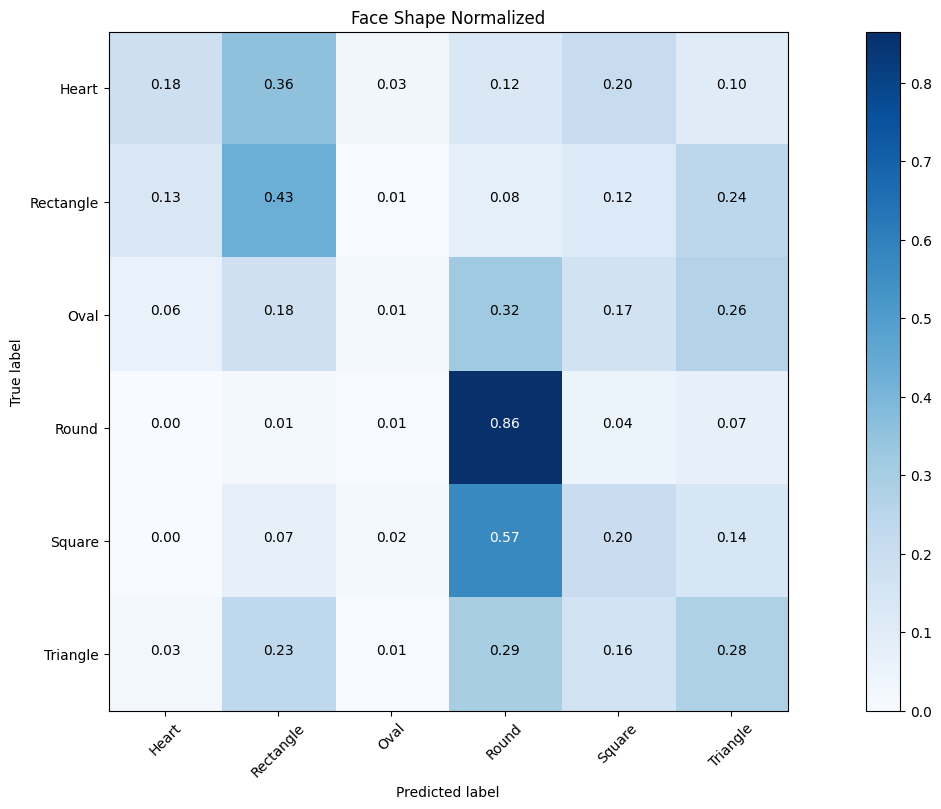

In [26]:
make_predictions(model_5)